DATTABAYÖ - Borja Esteve Molner & Jorge López Fresco

## Sesión 3/5 - Práctica 3 - LNR
### Validación de Clasificadores

___________

**Objetivo**: Ajustar los parámetros del clasificador propuesto para la tarea DETESTS empleando la medida de evaluación F1, y empleando un esquema de validación cruzada. Entregar código e informe con la explicación de la estrategia utilizada antes de la siguiente sesión.

**Importar Librerías**

In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Para llevar a cabo esta tercera tarea, vamos a trabajar con los 7 modelos creados en la sesión 2 de esta misma práctica. Volveremos a usar numpy para importar los datos de las representaciones utilizadas. 

Si bien es cierto, ya realizamos una prevalidación de los clasificadores en la sesión 2, en esta 3º tarea realizaremos una validación un poco más pormenorizada, además de comprobar si la elección final de nuestros modelos fue la más adecuada. Es decir, reevaluaremos los modelos, los validaremos y en caso de haber escogido la mejor opción, replantearemos de nuevos esos 7 como definitivos. 

Cabe reseñar que el modelo de 3-gramas tardo en torno a 1 hora en ejecutarse. Suponemos que de llevar a cabo una validación, el tiempo de ejecución puede ser demasiado elevado y por tanto, optaremos por no validarlo y elegir directamente el modelo propuesto en la sesión 2.

A continuación, cargaremos las siguientes representaciones de palabras de Word Embedding, que representa a la matriz X:  

In [ ]:
rutaData = "/content/drive/MyDrive/3º - GCD/2C - LENGUAJE NATURAL Y RECUPERACIÓN DE LA INFORMACIÓN/Prácticas LNR/Práctica 3 (Sesiones 1 a 5) - LNR/"
rutaNumpys = "/content/drive/MyDrive/3º - GCD/2C - LENGUAJE NATURAL Y RECUPERACIÓN DE LA INFORMACIÓN/Prácticas LNR/Práctica 3 (Sesiones 1 a 5) - LNR/02 - Segunda Entrega - Práctica 3/"

# Representación con Word Embedding - Ponderada
data_pond = np.loadtxt(rutaNumpys + "rep_pond_w_emb.txt")
# Representación con Word Embedding - Mediana
data_med = np.loadtxt(rutaNumpys + "rep_median_w_emb.txt")
# Representación con 3-gramas
data_ngram = np.loadtxt(rutaNumpys + "represent_ngramas.txt")

Además de la matriz `X`, necesitaremos un vector de etiquetas `Y` que contendrá valores binarios de la pertenencia o no a la clase "stereotype". Para ello cargaremos el dataset original de Training `train.csv`.

In [ ]:
df_detests = pd.read_csv(rutaData + "train.csv")
extra_Data = pd.DataFrame(df_detests['stereotype']).to_numpy()

Realizaremos el mismo proceso para todos modelos. De esta forma, vamos a comenzar por realizaar un GridSearch para ver cuál sería la mejor opción. En caso de que coincida con el que ya teníamos, procederemos a realizar un k-fold y a continuación estudiar el F1 score y el accuracy (ya que nuestros datos están balanceados y el accuracy es una métrica fiable). Si no coincide, cambiaremos de modelo para escoger la mejor configuración de hiperparámetros.

Al final, de los 6 modelos que teníamos, nos quedaremos con 2 para cada tipo de representación: 2 para la word embedding ponderada, 2 para word embedding mediana y otro (que será el mismo) para el de 3-gramas. 

## Representación con Word Embedding - Ponderada

In [ ]:
data1 = np.append(data_pond, extra_Data, axis=1)
X, y = data1[0:3817,0:300], data1[0:3817,300:301]
print(data_pond.shape, data1.shape)

(3817, 300) (3817, 301)


In [ ]:
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
x_train, x_eval, y_train, y_eval = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.3, random_state=42)

### Modelos con Support Vector Machine

#### **Realizamos el Grid Search**

Dado que en la sesión 2 ya realizamos un estudio de diferentes modelos con SVM, hay ciertos hiperparámetros que ya descartamos en su momento (por ejemplo, kernel = "poly") y que no consideramos necesaraio añadir en el proceso de grid search actual.

In [ ]:
clf = GridSearchCV(estimator=svm.SVC(), param_grid={'C': [7,10,20,30,40,50,60,100],
'kernel': ('rbf',)})
clf.fit(x_train, y_train)
#Obtener los mejores hiper-parámetros
print(clf.best_params_)
#Obtener el mejor clasificador
print(clf.best_estimator_)

{'C': 40, 'kernel': 'rbf'}
SVC(C=40)


El mejor resultado obtenido se produce para un C=40. Comprobando en el código, podemos ver que todas las métricas mejoran de forma sustancial y además, no se produce un gran desbalanceo de dichas medidas. Vemos que a partir de 40, los valores tiende sobreajustar la muestra y por tanto, empeorar la predicción, porque cuanto mayor es el valor de C, menor el margen, menos observaciones serán vectores soporte y el clasificador resultante tendrá menor bias pero mayor varianza. 

Por tanto, hemos establecido un punto de equilibrio entre bias y varianza, situado en c=40.

#### **Realizamos la Validación cruzada** usando k-fold de 10.

In [ ]:
kf = KFold(n_splits=10)

a, fma, fmi = [], [], []
for train, eval in kf.split(x_train):
    x_train_i, x_eval_i, y_train_i, y_eval_i = x_train[train], x_train[eval], y_train[train], y_train[eval]
    c = svm.SVC(kernel='rbf', gamma='scale', C=40).fit( x_train_i, y_train_i )
    p = c.predict(x_eval_i)
    acc = c.score(x_eval_i, y_eval_i)
    f1ma = f1_score(y_eval_i, p, average='macro')
    f1mi = f1_score(y_eval_i, p, average='micro')
    a.append(acc)
    fma.append(f1ma)
    fmi.append(f1mi)

In [ ]:
acc_med_clf1 = sum(a)/len(a)
f1ma_med_clf1 = sum(fma)/len(a)
f1mi_med_clf1 = sum(fmi)/len(a)

In [ ]:
print('Accuracy Medio SVM con C=40:', round(acc_med_clf1, 5))
print("F1 Score Macro Medio SVM con C=40:", round(f1ma_med_clf1, 5))
print("F1 Score Micro Medio SVM con C=40:", round(f1mi_med_clf1, 5))

Accuracy Medio SVM con C=40: 0.90245
F1 Score Macro Medio SVM con C=40: 0.90201
F1 Score Micro Medio SVM con C=40: 0.90245


Hemos elegido un k-fold de 10 porque de esta forma trabajamos con 10 muestras de 380 elementos aproximadamente. Los resultados obtenidos son bastante constantes y coherentes y los valores medios son muy prometedores y cercanos al valor obtenido por el modelo.

Como puede observarse, los valores obtenidos en las dos métricas (accuracy y F1) en los distintos Folds son muy parecidos entre ellos, por lo que podemos ver que el modelo es independiente de la muestra y que no estamos sufriendo problemas de sobreajuste.

#### **Validamos el modelo**

#### Modelo SVM - Ponderada Anterior
Modelo Anterior: SVM, Kernel Rbf, C=7, Gamma=Scale

In [ ]:
clf4 = svm.SVC(kernel='rbf',gamma = 'scale', C=7).fit( x_train, y_train )
pred4 = clf4.predict(x_eval)
acc_sig_svm4 = clf4.score(x_eval, y_eval)
pred_sc4 = pred4
print("Training set score: %f" % clf4.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', acc_sig_svm4)
print("F1 Score:", f1_score(y_eval, pred4, average='macro'))
print("\n", confusion_matrix(y_eval, pred_sc4))
print(classification_report(y_eval, pred_sc4) )

Training set score: 0.951225
Accuracy Radial Basis Kernel: 0.8862478777589134
F1 Score: 0.8861773010938186

 [[761 133]
 [ 68 805]]
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88       894
         1.0       0.86      0.92      0.89       873

    accuracy                           0.89      1767
   macro avg       0.89      0.89      0.89      1767
weighted avg       0.89      0.89      0.89      1767



#### Modelo SVM - Ponderada Nueva
Modelo Optimizado con Grid Search: SVM, Kernel Rbf, C=40, Gamma=Scale

In [ ]:
clf4 = svm.SVC(kernel='rbf',gamma = 'scale', C=40).fit( x_train, y_train )
pred4 = clf4.predict(x_eval)
acc_sig_svm4 = clf4.score(x_eval, y_eval)
pred_sc4 = pred4
print("Training set score: %f" % clf4.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', acc_sig_svm4)
print("F1 Score Macro:", f1_score(y_eval, pred4, average='macro'))
print("F1 Score Micro:", f1_score(y_eval, pred4, average='micro'))
print("F1 Score:", f1_score(y_eval, pred4, average=None))
print("\n", confusion_matrix(y_eval, pred_sc4))
print(classification_report(y_eval, pred_sc4) )

Training set score: 0.992963
Accuracy Radial Basis Kernel: 0.9134125636672326
F1 Score Macro: 0.913393812750011
F1 Score Micro: 0.9134125636672326
F1 Score: [0.91211947 0.91466815]

 [[794 100]
 [ 53 820]]
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91       894
         1.0       0.89      0.94      0.91       873

    accuracy                           0.91      1767
   macro avg       0.91      0.91      0.91      1767
weighted avg       0.91      0.91      0.91      1767



#### **Curva ROC y AUC**

Por último, vamos a añadir una curva ROC para calcular el área bajo la curva y verificar la calidad del modelo.

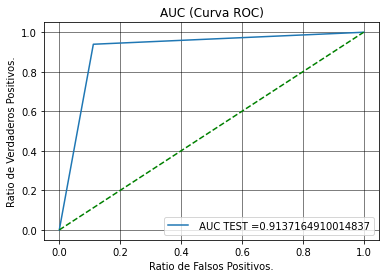

In [ ]:
test_fpr, test_tpr, te_thresholds = roc_curve(y_eval, pred4)
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("Ratio de Falsos Positivos.")
plt.ylabel("Ratio de Verdaderos Positivos.")
plt.title("AUC (Curva ROC)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

La métrica obtenida para el AUC de los datos de test es de 0.913, lo que implica un valor muy elevado y que denota una calidad muy elevada en el modelo. 

### Modelo con Multilayer Perceptron

#### **Realizamos el Grid Search**

In [ ]:
mlp = MLPClassifier(max_iter=1000)
parameter_space = {
    'hidden_layer_sizes': [(5,5,5), (10,10,10), (20,20,20),
                           (30,30,30), (50,50,50), (50,50,50)],
    'activation': ['logistic'],
    'solver': ['adam'],
    'alpha': [1e-4],
    'learning_rate': ['adaptive'],
}
clf2 = GridSearchCV(mlp, parameter_space)
clf2.fit(x_train, y_train)
print(clf2.best_params_)
print(clf2.best_estimator_)

{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (30, 30, 30), 'learning_rate': 'adaptive', 'solver': 'adam'}
MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30, 30),
              learning_rate='adaptive', max_iter=1000)


In [ ]:
mlp2 = MLPClassifier(max_iter=1000)
parameter_space = {
    'hidden_layer_sizes': [(10,10,10)],
    'activation': ['logistic','relu','tanh'],
    'solver': ['adam','sgd'],
    'alpha': [1e-4,0.05,0.1],
    'learning_rate': ['adaptive'],
}
clf2b = GridSearchCV(mlp2, parameter_space)
clf2b.fit(x_train, y_train)
print(clf2b.best_params_)
print(clf2b.best_estimator_)

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10, 10), 'learning_rate': 'adaptive', 'solver': 'adam'}
MLPClassifier(hidden_layer_sizes=(10, 10, 10), learning_rate='adaptive',
              max_iter=1000)


Para la configuración del modelo MLP, hemos probado con condiguraciones con distintos números de neuronas y 3 capas ocultas. Previamente probamos diferentes funciones de activación, solvers, etc. y con el fin de simplificar el cálculo (dado que computacionalmente requiere de mucho tiempo) hemos optado por variar el nº de neuronas y escoger el resto de parámetros en base a lo que la literatura dice que funciona mejor para un clasificador binario (solver="adam", activation="logistic"). 

En base a los resultados, la mejor configuración de capas ocultas y neuronas es (30,30,30).

Por otro lado, y teniendo en cuenta que nuestro modelo anterior con 3 capas ocultas de 10 neuronas cada una, es mejor que este, hemos probado la configuración de distintos hiperparámetros como la función de activación, los alphas, etc. 

El resultado con (10,10,10) nos dice que la mejor configuración es la que ya teníamos pero usando la función de activación "relu".

#### **Realizamos la Validación cruzada** usando k-fold de 10.

In [ ]:
kf = KFold(n_splits=10)

a, fma, fmi = [], [], []
for train, eval in kf.split(x_train):
    x_train_i, x_eval_i, y_train_i, y_eval_i = x_train[train], x_train[eval], y_train[train], y_train[eval]
    m = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000, alpha=1e-4,
                    solver='adam', activation='relu', random_state=1, learning_rate='adaptive',
                    learning_rate_init=.1)
    p = m.fit(x_train_i, y_train_i)
    acc = c.score(x_eval_i, y_eval_i)
    f1ma = f1_score(y_eval_i, m.predict(x_eval_i), average='macro')
    f1mi = f1_score(y_eval_i, m.predict(x_eval_i), average='micro')
    a.append(acc)
    fma.append(f1ma)
    fmi.append(f1mi)

In [ ]:
acc_med_clf1 = sum(a)/len(a)
f1ma_med_clf1 = sum(fma)/len(a)
f1mi_med_clf1 = sum(fmi)/len(a)

In [ ]:
print('Accuracy Medio MLP:', round(acc_med_clf1, 5))
print("F1 Score Macro Medio MLP:", round(f1ma_med_clf1, 5))
print("F1 Score Micro Medio MLP:", round(f1mi_med_clf1, 5))

Accuracy Medio SVM con C=40: 0.88475
F1 Score Macro Medio SVM con C=40: 0.81766
F1 Score Micro Medio SVM con C=40: 0.81946


En este caso, vemos como las métricas se reducen notablemente en comparación con el modelo propuesto anteriormente. Además, puede observarse que el valor de las métricas cambia bastante en cada fold, por lo que podemos deducir que este modelo no es independiente de la muestra si no que se ha sobreajustado a la muestra de entrenamiento, arrojando malos resultados cuando entran nuevos datos, por lo que lo mejor sería descartare este modelo.

Podemos ver que nuestro modelo previo era mejor que el que nos muestra el grid search.

#### **Validamos el modelo**

#### Modelo MLP - Ponderada
Modelo Anterior: MLP, 3 capas ocultas de 10 neuronas, solver=adam, activación=sigmoide.

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000, alpha=1e-4,
                    solver='adam', activation='logistic', random_state=1,
                    learning_rate_init=.1)
mlp.fit(x_train, y_train)
print("Training set score: %f" % mlp.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', mlp.score(x_eval, y_eval))
print("F1 Score Macro:", f1_score(y_eval, mlp.predict(x_eval), average='macro'))
print("F1 Score Micro:", f1_score(y_eval, mlp.predict(x_eval), average='micro'))
print("F1 Score :", f1_score(y_eval, mlp.predict(x_eval), average=None))
print("\n", confusion_matrix(y_eval, mlp.predict(x_eval)))
print(classification_report(y_eval, mlp.predict(x_eval)))

Training set score: 0.972579
Accuracy Radial Basis Kernel: 0.8698358800226372
F1 Score Macro: 0.8697787831793189
F1 Score Micro: 0.8698358800226371
F1 Score : [0.86705202 0.87250554]

 [[750 144]
 [ 86 787]]
              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87       894
         1.0       0.85      0.90      0.87       873

    accuracy                           0.87      1767
   macro avg       0.87      0.87      0.87      1767
weighted avg       0.87      0.87      0.87      1767



#### Modelo MLP - Ponderada Nueva
Modelo Nuevo: MLP, 3 capas ocultas de 30 neuronas, solver=adam, activación=relu.

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30), max_iter=1000, alpha=1e-4,
                    solver='adam', activation='logistic', random_state=1,
                    learning_rate_init=.1)
mlp.fit(x_train, y_train)
print("Training set score: %f" % mlp.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', mlp.score(x_eval, y_eval))
print("F1 Score Macro:", f1_score(y_eval, mlp.predict(x_eval), average='macro'))
print("F1 Score Micro:", f1_score(y_eval, mlp.predict(x_eval), average='micro'))
print("F1 Score :", f1_score(y_eval, mlp.predict(x_eval), average=None))
print("\n", confusion_matrix(y_eval, mlp.predict(x_eval)))
print(classification_report(y_eval, mlp.predict(x_eval)))

Training set score: 0.962630
Accuracy Radial Basis Kernel: 0.8641765704584041
F1 Score Macro: 0.8639691447839442
F1 Score Micro: 0.8641765704584041
F1 Score : [0.85865724 0.86928105]

 [[729 165]
 [ 75 798]]
              precision    recall  f1-score   support

         0.0       0.91      0.82      0.86       894
         1.0       0.83      0.91      0.87       873

    accuracy                           0.86      1767
   macro avg       0.87      0.86      0.86      1767
weighted avg       0.87      0.86      0.86      1767



#### Modelo MLP - Ponderada Nueva 2
Modelo Nuevo 2: MLP, 3 capas ocultas de 10 neuronas, solver=adam, activación=relu.

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000, alpha=1e-4,
                    solver='adam', activation='relu', random_state=1,
                    learning_rate_init=.1)
mlp.fit(x_train, y_train)
print("Training set score: %f" % mlp.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', mlp.score(x_eval, y_eval))
print("F1 Score Macro:", f1_score(y_eval, mlp.predict(x_eval), average='macro'))
print("F1 Score Micro:", f1_score(y_eval, mlp.predict(x_eval), average='micro'))
print("F1 Score :", f1_score(y_eval, mlp.predict(x_eval), average=None))
print("\n", confusion_matrix(y_eval, mlp.predict(x_eval)))
print(classification_report(y_eval, mlp.predict(x_eval)))

Training set score: 0.905605
Accuracy Radial Basis Kernel: 0.8290888511601585
F1 Score Macro: 0.8286343516137402
F1 Score Micro: 0.8290888511601585
F1 Score : [0.81980907 0.83745963]

 [[687 207]
 [ 95 778]]
              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82       894
         1.0       0.79      0.89      0.84       873

    accuracy                           0.83      1767
   macro avg       0.83      0.83      0.83      1767
weighted avg       0.83      0.83      0.83      1767



El mejor modelo de los 3 es el anterior (Modelo MLP - Ponderado) y por tanto, dejaremos ese modelo para la fase final de esta práctica. 

#### **Curva ROC y AUC**

Por último, vamos a añadir una curva ROC para calcular el área bajo la curva y verificar la calidad del modelo.

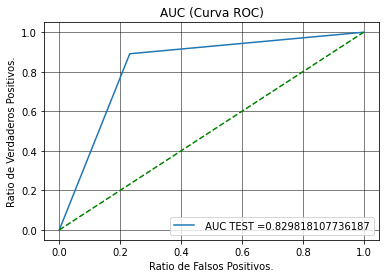

In [ ]:
test_fpr, test_tpr, te_thresholds = roc_curve(y_eval, mlp.predict(x_eval))
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("Ratio de Falsos Positivos.")
plt.ylabel("Ratio de Verdaderos Positivos.")
plt.title("AUC (Curva ROC)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

La métrica obtenida para el AUC de los datos de test es de 0.83, lo que implica un valor aceptable y que denota una calidad más o menos buena en el modelo. No se acerca, de todas formas, al modelo obtenido con SVM.

________________

### Resultados Word Embedding Ponderado

**Modelos Elegidos**

1. El modelo con SVM, kernel Radial, c=40 y gamma="scale".  

                precision    recall  f1-score

         0.0       0.94      0.89      0.91
         1.0       0.89      0.94      0.91

2. El modelo con MLP, 3 capas ocultas de 10 neuronas, solver=adam, activación=sigmoide.

                precision    recall  f1-score

         0.0       0.90      0.84      0.87
         1.0       0.85      0.90      0.87

____________________

## Representación con Word Embedding - Mediana

In [ ]:
data2 = np.append(data_med, extra_Data, axis=1)
X, y = data2[0:3817,0:300], data2[0:3817,300:301]
print(data_med.shape, data2.shape)

(3817, 300) (3817, 301)


In [ ]:
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
x_train, x_eval, y_train, y_eval = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.3, random_state=42)

### Modelos con Support Vector Machine

#### **Realizamos el Grid Search**

Como el mejor modelo obtenido en SVM para word embedding con mediana era un Kernel = "poly", vamos a realizar el grid search con este mismo método (hemos probado también con "rbf" pero los resultados, como era de esperar, son peores). 

In [ ]:
clf = GridSearchCV(estimator=svm.SVC(), param_grid={'C': [7,10,30,50,70],
'kernel': ('poly',), 'degree': [3,4,5]})
clf.fit(x_train, y_train)
#Obtener los mejores hiper-parámetros
print(clf.best_params_)
#Obtener el mejor clasificador
print(clf.best_estimator_)

{'C': 70, 'degree': 3, 'kernel': 'poly'}
SVC(C=70, kernel='poly')


El mejor resultado obtenido se produce para un C=70. Comprobando en el código, podemos ver que todas las métricas mejoran, aunque de forma muy sutil y además, no se produce un gran desbalanceo de dichas medidas. Dado que se trata de un modelo con kernel polinómico, hemos probado diferentes polinomios y la mejor opción es la de grado 3.

#### **Realizamos la Validación cruzada** usando k-fold de 10.

In [ ]:
kf = KFold(n_splits=10)

a, fma, fmi = [], [], []
for train, eval in kf.split(x_train):
    x_train_i, x_eval_i, y_train_i, y_eval_i = x_train[train], x_train[eval], y_train[train], y_train[eval]
    c = svm.SVC(kernel='poly', degree=3, C=70).fit( x_train_i, y_train_i )
    p = c.predict(x_eval_i)
    acc = c.score(x_eval_i, y_eval_i)
    f1ma = f1_score(y_eval_i, p, average='macro')
    f1mi = f1_score(y_eval_i, p, average='micro')
    a.append(acc)
    fma.append(f1ma)
    fmi.append(f1mi)

In [ ]:
acc_med_clf1 = sum(a)/len(a)
f1ma_med_clf1 = sum(fma)/len(a)
f1mi_med_clf1 = sum(fmi)/len(a)

In [ ]:
print('Accuracy Medio SVM con C=70:', round(acc_med_clf1, 5))
print("F1 Score Macro Medio SVM con C=70:", round(f1ma_med_clf1, 5))
print("F1 Score Micro Medio SVM con C=70:", round(f1mi_med_clf1, 5))

Accuracy Medio SVM con C=40: 0.87015
F1 Score Macro Medio SVM con C=40: 0.86922
F1 Score Micro Medio SVM con C=40: 0.87015


Tenemos un accuracy muy parecido al F1, lo que nos da a entender que se trata de un modelo sólido.

Las métricas calculadas en cada fold no difieren entre ellas por lo que además puede verse que el modelo es independiente de la muestra.

#### Modelo SVM - Mediana Anterior
Modelo Anterior: SVM, Kernel Polinómico grado 4, C=8

In [ ]:
clf3 = svm.SVC(kernel='poly', C=8, degree=4).fit( x_train, y_train )
pred3 = clf3.predict(x_eval)
acc_pol_svm3 = clf3.score(x_eval, y_eval)
pred_sc3 = pred3
print("Training set score: %f" % clf3.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', acc_pol_svm3)
print("F1 Score:", f1_score(y_eval, pred3, average='macro'))
print("\n", confusion_matrix(y_eval, pred_sc3))
print(classification_report(y_eval, pred_sc3))

Training set score: 0.953641
Accuracy Radial Basis Kernel: 0.8527746319365799
F1 Score: 0.8515561452445334

 [[673 203]
 [ 57 833]]
              precision    recall  f1-score   support

         0.0       0.92      0.77      0.84       876
         1.0       0.80      0.94      0.87       890

    accuracy                           0.85      1766
   macro avg       0.86      0.85      0.85      1766
weighted avg       0.86      0.85      0.85      1766



#### Modelo SVM - Mediana Nuevo
Modelo Nuevo: SVM, Kernel Polinómico grado 3, C=70

In [ ]:
clf3 = svm.SVC(kernel='poly', C=70, degree=3).fit( x_train, y_train )
pred3 = clf3.predict(x_eval)
acc_pol_svm3 = clf3.score(x_eval, y_eval)
pred_sc3 = pred3
print("Training set score: %f" % clf3.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', acc_pol_svm3)
print("F1 Score:", f1_score(y_eval, pred3, average='macro'))
print("\n", confusion_matrix(y_eval, pred_sc3))
print(classification_report(y_eval, pred_sc3))

Training set score: 0.994903
Accuracy Radial Basis Kernel: 0.8708946772366931
F1 Score: 0.8703544382051414

 [[712 164]
 [ 64 826]]
              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86       876
         1.0       0.83      0.93      0.88       890

    accuracy                           0.87      1766
   macro avg       0.88      0.87      0.87      1766
weighted avg       0.88      0.87      0.87      1766



#### **Curva ROC y AUC**

Por último, vamos a añadir una curva ROC para calcular el área bajo la curva y verificar la calidad del modelo.

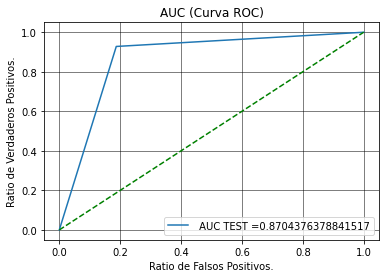

In [ ]:
test_fpr, test_tpr, te_thresholds = roc_curve(y_eval, pred3)
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("Ratio de Falsos Positivos.")
plt.ylabel("Ratio de Verdaderos Positivos.")
plt.title("AUC (Curva ROC)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

La métrica obtenida para el AUC de los datos de test es de 0.87, lo que implica un valor elevado y que denota una calidad buena en el modelo. 

### Modelos con Multilayer Perceptron

#### **Realizamos el Grid Search**

In [ ]:
mlp2 = MLPClassifier(max_iter=1000)
parameter_space = {
    'hidden_layer_sizes': [(10,10,10)],
    'activation': ['logistic','relu','tanh'],
    'solver': ['adam','sgd'],
    'alpha': [1e-4,0.05,0.1],
    'learning_rate': ['adaptive'],
}
clf2b = GridSearchCV(mlp2, parameter_space)
clf2b.fit(x_train, y_train)
print(clf2b.best_params_)
print(clf2b.best_estimator_)

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (10, 10, 10), 'learning_rate': 'adaptive', 'solver': 'adam'}
MLPClassifier(alpha=0.05, hidden_layer_sizes=(10, 10, 10),
              learning_rate='adaptive', max_iter=1000)


Dadas las circunstancias y teniendo en cuenta que nuestro modelo anterior para word embedding ponderada tiene la misma configuración que el de word embedding mediana, usaremos el mismo código para hacer el grid search. Es decir, asumiremos que la mejor configuración es, de nuevo con 3 capas de 10 neuronas y probaremos diferentes activadores y solvers. No obstante, realizamos la prueba dado que los datos disponibles son diferentes a los de la representación ponderada.   

El resultado con (10,10,10) nos dice que la mejor configuración es la que ya teníamos pero usando la función de activación "relu" y usando un alpha de 0.05 en lugar de 1e-4.

No obstante, y debido a que el modelo (10,10,10), al realizar el k-fold muestra valores de accuracy y F1 muy descompensados, volvermos a repetir el grid search para diferentes números de neuronas pero manteniendo el activador "relu" y los demás parámetros iguales, a ver si conseguimos mejorarlo.

In [ ]:
mlp = MLPClassifier(max_iter=1000)
parameter_space = {
    'hidden_layer_sizes': [(5,5,5), (10,10,10), (20,20,20),
                           (30,30,30), (50,50,50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.05],
    'learning_rate': ['adaptive'],
}
clf2 = GridSearchCV(mlp, parameter_space)
clf2.fit(x_train, y_train)
print(clf2.best_params_)
print(clf2.best_estimator_)

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
MLPClassifier(alpha=0.05, hidden_layer_sizes=(50, 50, 50),
              learning_rate='adaptive', max_iter=1000)


Realizamos una última prueba con dos capas ocultas de 10 neuronas y vemos que las métricas mejoran de nuevo, pero siguen sin alcanzar a las obtenidas en el modelo obtenido en la sesión 2. 

In [ ]:
mlp = MLPClassifier(max_iter=1000)
parameter_space = {
    'hidden_layer_sizes': [(10,10)],
    'activation': ['logistic'],
    'solver': ['adam'],
    'alpha': [1e-4],
}
clf2 = GridSearchCV(mlp, parameter_space)
clf2.fit(x_train, y_train)
print(clf2.best_params_)
print(clf2.best_estimator_)

{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10), 'solver': 'adam'}
MLPClassifier(activation='logistic', hidden_layer_sizes=(10, 10), max_iter=1000)


#### **Realizamos la Validación cruzada** usando k-fold de 10.

In [ ]:
kf = KFold(n_splits=10)

a, fma, fmi = [], [], []
for train, eval in kf.split(x_train):
    x_train_i, x_eval_i, y_train_i, y_eval_i = x_train[train], x_train[eval], y_train[train], y_train[eval]
    m = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000, alpha=1e-4,
                    solver='adam', activation='logistic', random_state=1,
                    learning_rate_init=.1)
    p = m.fit(x_train_i, y_train_i)
    acc = c.score(x_eval_i, y_eval_i)
    f1ma = f1_score(y_eval_i, m.predict(x_eval_i), average='macro')
    f1mi = f1_score(y_eval_i, m.predict(x_eval_i), average='micro')
    a.append(acc)
    fma.append(f1ma)
    fmi.append(f1mi)

In [ ]:
acc_med_clf1 = sum(a)/len(a)
f1ma_med_clf1 = sum(fma)/len(a)
f1mi_med_clf1 = sum(fmi)/len(a)

In [ ]:
print('Accuracy Medio SVM con C=40:', round(acc_med_clf1, 5))
print("F1 Score Macro Medio SVM con C=40:", round(f1ma_med_clf1, 5))
print("F1 Score Micro Medio SVM con C=40:", round(f1mi_med_clf1, 5))

Accuracy Medio SVM con C=40: 0.98519
F1 Score Macro Medio SVM con C=40: 0.82854
F1 Score Micro Medio SVM con C=40: 0.82985


Con la configuración de (10,10,10) obtenemos un accuracy muy alto y nada parecido al F1, lo que nos da a entender que se trata de un modelo poco sólido.Por otro lado, las métricas cambian mucho en cada fold, por lo que además, podemos ver que el modelo no es independiente de la muestra. A continuación, se adjuntan las métricas: 

- Accuracy Medio SVM con C=40: 0.98519
- F1 Score Macro Medio SVM con C=40: 0.71957
- F1 Score Micro Medio SVM con C=40: 0.73883

Probando con la nueva configuración de (50,50,50), vemos que empeora aún más.

- Accuracy Medio SVM con C=40: 0.98519
- F1 Score Macro Medio SVM con C=40: 0.65196
- F1 Score Micro Medio SVM con C=40: 0.6932

La decisión final es optar por el modelo inicial que creamos, que muestra mejores resultados. Usando (10,10,10), con logistic, adam y sin adaptativo. 

- Accuracy Medio SVM con C=40: 0.98519
- F1 Score Macro Medio SVM con C=40: 0.82854
- F1 Score Micro Medio SVM con C=40: 0.82985

#### **Validamos el modelo**

#### Modelo MLP - Mediana Anterior
Modelo Anterior: MLP, 3 capas ocultas de 10 neuronas, solver=adam, activation=sigmoide

In [ ]:
mlp2 = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000, alpha=1e-4,
                    solver='adam', activation='logistic', random_state=1,
                    learning_rate_init=.1)
mlp2.fit(x_train, y_train)
print("Training set score: %f" % mlp2.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', mlp2.score(x_eval, y_eval))
print("F1 Score Macro:", f1_score(y_eval, mlp2.predict(x_eval), average='macro'))
print("F1 Score Micro:", f1_score(y_eval, mlp2.predict(x_eval), average='micro'))
print("F1 Score :", f1_score(y_eval, mlp2.predict(x_eval), average=None))
print("\n", confusion_matrix(y_eval, mlp2.predict(x_eval)))
print(classification_report(y_eval, mlp2.predict(x_eval)))

Training set score: 0.962621
Accuracy Radial Basis Kernel: 0.8431483578708947
F1 Score Macro: 0.8426737189512781
F1 Score Micro: 0.8431483578708947
F1 Score : [0.83403235 0.85131508]

 [[696 180]
 [ 97 793]]
              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83       876
         1.0       0.82      0.89      0.85       890

    accuracy                           0.84      1766
   macro avg       0.85      0.84      0.84      1766
weighted avg       0.85      0.84      0.84      1766



#### Modelo MLP - Mediana Nuevo
Modelo Nuevo: MLP, 2 capas ocultas de 10 neuronas, solver=adam, activation=sigmoide

In [ ]:
mlp2 = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=1000, alpha=1e-4,
                    solver='adam', activation='logistic', random_state=1,
                    learning_rate_init=.1)
mlp2.fit(x_train, y_train)
print("Training set score: %f" % mlp2.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', mlp2.score(x_eval, y_eval))
print("F1 Score Macro:", f1_score(y_eval, mlp2.predict(x_eval), average='macro'))
print("F1 Score Micro:", f1_score(y_eval, mlp2.predict(x_eval), average='micro'))
print("F1 Score :", f1_score(y_eval, mlp2.predict(x_eval), average=None))
print("\n", confusion_matrix(y_eval, mlp2.predict(x_eval)))
print(classification_report(y_eval, mlp2.predict(x_eval)))

Training set score: 0.970146
Accuracy Radial Basis Kernel: 0.8318233295583239
F1 Score Macro: 0.8309490634871675
F1 Score Micro: 0.8318233295583239
F1 Score : [0.81879195 0.84310618]

 [[671 205]
 [ 92 798]]
              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82       876
         1.0       0.80      0.90      0.84       890

    accuracy                           0.83      1766
   macro avg       0.84      0.83      0.83      1766
weighted avg       0.84      0.83      0.83      1766



#### **Curva ROC y AUC**

Por último, vamos a añadir una curva ROC para calcular el área bajo la curva y verificar la calidad del modelo.

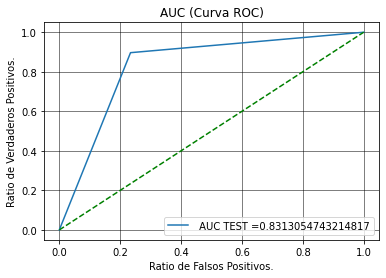

In [ ]:
test_fpr, test_tpr, te_thresholds = roc_curve(y_eval, mlp2.predict(x_eval))
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("Ratio de Falsos Positivos.")
plt.ylabel("Ratio de Verdaderos Positivos.")
plt.title("AUC (Curva ROC)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

La métrica obtenida para el AUC de los datos de test es de 0.83, lo que implica un valor aceptable y que denota una calidad más o menos buena en el modelo. No se acerca, de todas formas, al modelo obtenido con SVM.

________________

### Resultados Word Embedding con Mediana

**Modelos Elegidos**

1. El modelo con SVM, kernel Polinónico, c=70 y degree=3.  

              precision    recall  f1-score

         0.0       0.92      0.81      0.86
         1.0       0.83      0.93      0.88

2. El modelo con MLP, 3 capas ocultas de 10 neuronas, solver=adam, activación=sigmoide.

              precision    recall  f1-score

         0.0       0.88      0.79      0.83
         1.0       0.82      0.89      0.85 

____________________

## Representación con 3-Gramas

En este caso, y dado que el coste computacional de este modelo es tan elevado, no llevaremos a cabo el grid search ni el K-fold. Asumimos que el tiempo de cálculo sería tan alto que no es viable para esta práctica. De este modo, dejaremos el código de la sesión anterior y usaremos este modelo tal y cómo lo construimos. 

In [ ]:
data3 = np.append(data_ngram, extra_Data, axis=1)
X, y = data3[0:3817,0:42766], data3[0:3817,42766:42767]
print(data_ngram.shape, data3.shape)

(3817, 42766) (3817, 42767)


In [ ]:
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
x_train, x_eval, y_train, y_eval = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.3, random_state=42)

In [ ]:
print(x_train.shape, y_train.shape)

(4124, 42766) (4124,)


#### Modelo 3_Gramas Anterior
Modelo Anterior: SVM, Kernel Rbf, C2, Gamma Scale

In [ ]:
clf5 = svm.SVC( kernel='rbf', C=2, gamma='scale' ).fit( x_train, y_train )
pred5 = clf5.predict(x_eval)
acc_rbf_svm5 = clf5.score(x_eval, y_eval)
pred_sc5 = pred5
print("Training set score: %f" % clf5.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', acc_rbf_svm5)
print("F1 Score:", f1_score(y_eval, pred5, average='macro'))
print("\n", confusion_matrix(y_eval, pred_sc5))
print(classification_report(y_eval, pred_sc5))

Training set score: 0.952473
Accuracy Radial Basis Kernel: 0.8110859728506787
F1 Score: 0.8106983853429351

 [[677 234]
 [100 757]]
              precision    recall  f1-score   support

         0.0       0.87      0.74      0.80       911
         1.0       0.76      0.88      0.82       857

    accuracy                           0.81      1768
   macro avg       0.82      0.81      0.81      1768
weighted avg       0.82      0.81      0.81      1768



_____________

### Resultados 3-Gramas

**Modelos Elegidos**

1. El modelo con SVM, kernel rbf, C=2 y Gamma=scale. 

               precision    recall  f1-score

         0.0       0.87      0.74      0.80
         1.0       0.76      0.88      0.82
_____________

## Relación final de Modelos

Estos son nuestros 5 modelos elegidos:

**Word Embedding Ponderado**

1. El modelo con SVM, kernel Radial, c=40 y gamma="scale".  

                precision    recall  f1-score

         0.0       0.94      0.89      0.91
         1.0       0.89      0.94      0.91

2. El modelo con MLP, 3 capas ocultas de 10 neuronas, solver=adam, activación=sigmoide.

                precision    recall  f1-score

         0.0       0.90      0.84      0.87
         1.0       0.85      0.90      0.87

**Word Embedding Mediana**

1. El modelo con SVM, kernel Polinónico, c=70 y degree=3.  

              precision    recall  f1-score

         0.0       0.92      0.81      0.86
         1.0       0.83      0.93      0.88

2. El modelo con MLP, 3 capas ocultas de 10 neuronas, solver=adam, activación=sigmoide.

              precision    recall  f1-score

         0.0       0.88      0.79      0.83
         1.0       0.82      0.89      0.85 

**3-Gramas**

1. El modelo con SVM, kernel rbf, C=2 y Gamma=scale. 

               precision    recall  f1-score

         0.0       0.87      0.74      0.80
         1.0       0.76      0.88      0.82